# Experiment 1A2H

Randomly sample 2 raters N times. 
Evaluate automated scores against different pairs of raters. 
Show wide spread in r but more stable PRMSE. Hopefully it will be close to what we know to be true PRMSE. 

In [88]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import numpy as np

import itertools

from rsmtool.prmse_utils import compute_prmse

In [37]:
df = pd.read_csv('../data/data.csv')
N_raters = 1000
df['system'] = df['sys_7']

In [3]:
df.head()

,id,true,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,sys_0,sys_1,sys_2,sys_3,sys_4,sys_5,sys_6,sys_7,sys_8,sys_9
0,id_0,1.482912,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.662256,1.344181,-0.983512,1.542307,1.442852,0.696336,0.421272,1.655732,2.521383,1.348612
1,id_1,2.928792,3.0,3.0,3.0,3.0,0.0,3.0,4.0,3.0,...,2.992124,3.057749,4.357314,3.024483,2.913744,2.802713,3.428303,3.014486,3.718120,2.920634
2,id_2,3.488748,3.0,3.0,3.0,3.0,3.0,4.0,6.0,4.0,...,3.447440,3.491013,4.089049,3.422433,3.484840,3.004988,4.201792,3.672021,4.063527,3.454895
3,id_3,2.517567,2.0,3.0,2.0,3.0,2.0,3.0,3.0,3.0,...,2.472868,2.668394,1.135607,2.461948,2.515371,1.090372,2.306769,2.230356,3.482175,2.541851
4,id_4,3.370093,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,...,3.252322,3.379907,3.082338,3.295839,3.362012,5.035298,1.939673,3.389967,4.529199,3.338036


In [30]:
# generate all possible pairs of raters
raters = ['h_{}'.format(h) for h in range(0, N_raters)]
# we do the following to keep the array unidimensional
rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]

In [33]:
# randomly sample X pairs
N_pairs = 100
np.random.seed(100)
selected_pairs = np.random.choice(rater_pairs, N_pairs, replace=False)

In [39]:
# we make one long DF to speed up computation
data = []
for p in selected_pairs:
    (h1, h2) = p.split('+')
    df_p = pd.DataFrame({'pair': p,
                          'h1': df[h1],
                          'h2': df[h2],
                          'system': df['system']})
    data.append(df_p)
df_long = pd.concat(data)

1000000

In [79]:
# compute mean score
df_long['h_mean'] = (df_long['h1'] + df_long['h2'])/2

## Correlations

In [81]:
true_corr = pearsonr(df['system'], df['true'])[0]
true_corr

0.812704770910964

In [82]:
# let's compute correlations
df_corr = df_long.groupby('pair').corr().unstack().sort_values(by=('h1', 'h2'))
df_corr.columns = ['_'.join(col) for col in df_corr.columns]
len(df_corr)

100

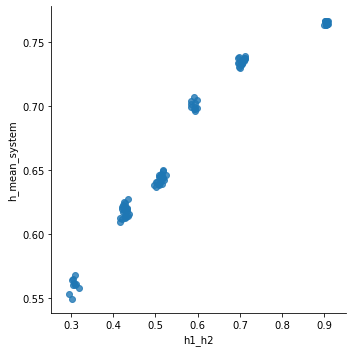

In [83]:
sns.lmplot(x='h1_h2', y='h_mean_system', data=df_corr, fit_reg=False)

## R2

In [84]:
# baseline: system r2 with true score.
true_r2 = r2_score(df['true'], df['system'])
true_r2

0.4806429504711086

In [120]:
df_r2 = pd.DataFrame(df_long.groupby('pair').apply(lambda x: r2_score(x['h_mean'], x['system'])))
df_r2.columns=['value']
df_r2['Metrics'] = 'R2'

In [121]:
df_prmse_all = df_long.groupby('pair').apply(lambda x: compute_prmse(x,
                                                                 system_score_columns=['system'],
                                                                 h1_column='h1',
                                                                 h2_column='h2')).reset_index(level=1, drop=True)
df_prmse = df_prmse_all[['prmse_true']].copy()
df_prmse.columns = ['value']
df_prmse['Metrics'] = 'PRMSE'

In [122]:
df_res = pd.concat([df_r2, df_prmse], sort=True)

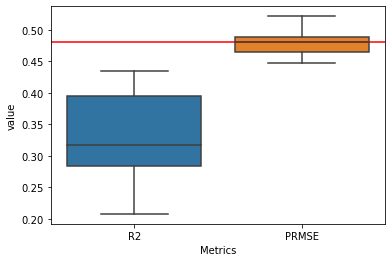

In [126]:
ax=sns.boxplot(x='Metrics', y='value', data=df_res)
ax.axhline(true_r2, color='red')

In [127]:
df_res.groupby('Metrics')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Metrics,,,,,,,,
PRMSE,100.0,0.478848,0.017787,0.447990,0.465365,0.480751,0.489214,0.521781
R2,100.0,0.335277,0.065578,0.207647,0.283785,0.316479,0.394589,0.434041


In [131]:
df_with_h = pd.merge(df_res, df_corr, right_index=True, left_index=True)
len(df_with_h)

200

In [ ]:
ax = sns.catplot(x='h1_h2', y='value', hue="Metrics", data=df_with_h)
ax.axhline(true_r2, color='red')